# Principal Component Analysis (PCA) implementation
This Jupyter Notebook contains implementation of two approaches for applying PCA and computing explained variance.
* Computing PCA via **covariance matrix** - this is useful when number of features is lower than number of records.
* Computing PCA via **Singular Value Decomposition (SVD)** - this approach is used in practice the most (Scikit-Learn library utilizes SVD for PCA).

The methods are applied on Iris data set. And PCA implementation from Scikit-Learn is used to compare the outputs of custom implementation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets


def plot_iris(X_trans, y, y_names, *, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(*X_trans.T, c=y)
    scatter_objects, _ = scatter.legend_elements()
    plt.legend(scatter_objects, y_names, loc='lower left', title='Classes')
    plt.title(title)
    plt.show()

In [2]:
# %% load data
dataset = datasets.load_iris()

X = dataset.data
y = dataset.target
y_names = dataset.target_names

## PCA through covariance matrix

Computing PCA through covariance matrix can be considered as the most simple and straightforward approach. The approach utilizes Eigenvector Decomposition which is applied on covariance matrix of $X$.

Given the input matrix X of dimensions $[n, m]$, the approach coveres following steps:
1. Center the data - that is subsracting off the mean for each dimension so that the data would have zero mean allong each dimension.

    This step can be considered similar to Standardization that is definded such as
    $$x_{standardized} = \frac{x - \bar{x}}{\sigma},$$

    where $\bar{x}$ and $\sigma$ denote mean and standard deviation, respectively, and $x$ and $x_{standardized}$ denote original variable and scaled variable, respectively. But due to the nature of PCA we cannot simply standartize the data because we will lose information about variance. Thus, centering the data si done by
    $$x_{centered} = x - \bar{x}.$$


2. Compute the covariance matrix - this is done by applying formula $C_X = \frac{1}{n}X^TX$, where $n$ is number of records (samples). For details of deriving this formula refer to **A Tutorial on Principal Component Analysis** [1]. Note, that in practice covariance is calcualted as $C_X = \frac{1}{n-1}X^TX$, where the slight change arrises from estimation theory.
3. Find eigen vectors - for this we will use a method from `NumPy`.
4. Compute the output $X_{transformed}$, i.e. matrix of projected data - this is done by applying the dot product for the input matrix and eigen vectors.
5. Retrieve explained variance vector which is a diagonal of the covariance matrix of $X_{transformed}$.


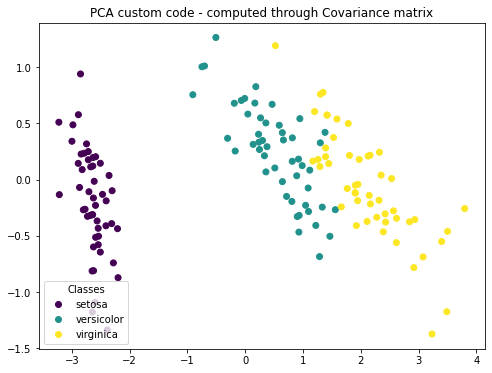

In [3]:
def pca_through_covariance_matrix(X, n_components=2):
    X = X.copy()
    n_samples, n_features = X.shape

    # center data - i.e. subtract off the mean for each dimension
    X -= np.mean(X, axis=0)
    assert np.allclose(X.mean(axis=0), np.zeros(X.shape[1]))

    # compute covariance matrix
    C = (X.T @ X) / (n_samples - 1)

    # find eigenvalues and eigenvectors (in this order)
    w, v = np.linalg.eig(C)

    # project the original data set
    X_trans = X @ v

    # get variance explained
    C_trans = (X_trans.T @ X_trans) / (n_samples - 1)
    exp_variance = C_trans.diagonal()
    exp_variance_pct = exp_variance / exp_variance.sum()

    # select only first two principal components
    X_trans = X_trans[:, :n_components]

    # note: In this implementation, we using full array of explaind variance.
    #       But implementation of Scikit-Learn is croping the array
    #       and storing only explained variance of n_components.

    return X_trans, exp_variance, exp_variance_pct


# %% custom pca (covariance matrix)
X_trans_cov, exp_variance_cov, exp_variance_pct_cov = pca_through_covariance_matrix(X)
plot_iris(X_trans_cov, y, y_names, title='PCA custom code - computed through Covariance matrix')

## PCA through Singular Value Decomposition (SVD)

This approach utilizes Singular Value Decomposition instead of Eigenvector Decomposition to solve PCA.

1. Center the data - same as for covariance matrix approach.
2. Apply Singluar Value Decomposition and obtain factorization in a form
$$X = U \Sigma V^T$$
3. Compute the output $X_{transformed}$ by multiplying $U$ and a digonal of $\Sigma$.
4. Retrieve explained variance vector which equals to 
$$\frac{S^2}{n - 1}$$
where $S$ is a vector of elements on the main diagonal of $\Sigma$.

Detailed explanation and interpretation can be found in [1].

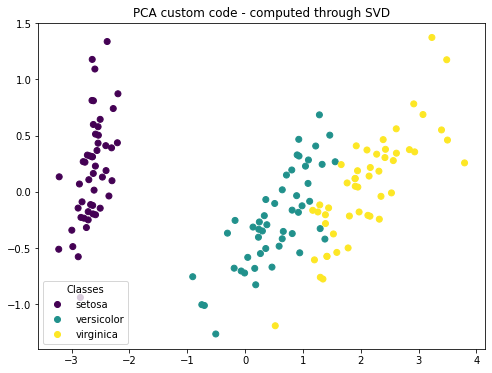

In [4]:
from sklearn.utils.extmath import svd_flip


def pca_through_svd(X, n_components=2):
    """
    Pieces of code were taken from scikit-learn library.
    See documentation page https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    """
    X = X.copy()
    n_samples, n_features = X.shape

    # center data - i.e. subtract off the mean for each dimension
    X -= np.mean(X, axis=0)
    assert np.allclose(X.mean(axis=0), np.zeros(X.shape[1]))

    # compute singular value decomposition (SVD)
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    U, Vt = svd_flip(U, Vt)  # flip eigenvectors' sign to enforce deterministic output

    # project the original data set
    # formula goes as: X_trans = X * V = U * S * V^T * V = U * S
    X_trans = U[:, :n_components] * S[:n_components]

    # get variance explained
    exp_variance = (S ** 2) / (n_samples - 1)
    exp_variance_pct = exp_variance / exp_variance.sum()

    # note: In this implementation, we using full array of explaind variance.
    #       But implementation of Scikit-Learn is croping the array
    #       and storing only explained variance of n_components.

    return X_trans, exp_variance, exp_variance_pct


# %% custom pca (with SVD) - utilized code from scikit-learn
X_trans_svd, exp_variance_svd, exp_variance_pct_svd = pca_through_svd(X)
plot_iris(X_trans_svd, y, y_names, title='PCA custom code - computed through SVD')

## Scikit-Learn implementation of PCA

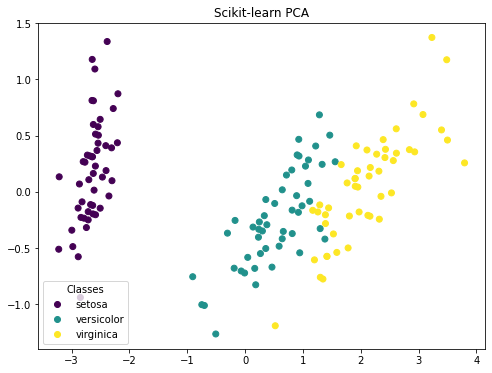

In [5]:
from sklearn.decomposition import PCA

def pca_scikit_learn(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_trans = pca.fit_transform(X)
    return X_trans, pca.explained_variance_, pca.explained_variance_ratio_


# %% pca from scikit-learn - this implementation utilizes SVD
X_trans_sk, exp_variance_sk, exp_variance_pct_sk = pca_scikit_learn(X)
plot_iris(X_trans_sk, y, y_names, title='Scikit-learn PCA')

## Comparison of variables

The cell below shows comparisons of $X_{transformed}$ created through different implementations.

We can see that the custom SVD implemetation has the same result as the Scikit-Learn implementation.
However the results of the Covariance Matrix and SVD implementations do not match. This is because the output is rotated on y-axis (this can be seen in the figures). So if we rotate output of the Covariance Matrix implementation and compare again, the equality would be satisfied. Therefore, we can confirm that all functions produce the same results and custom implemented functions work correctly.

Similarly, we observe the explained variance is computed correctly and all results equal.

In [6]:
# %% compare variables
# compare output data
print('Output of custom SVD implementation is same as output of Scikit-Learn implementation:\n',
      np.allclose(X_trans_svd, X_trans_sk), '\n')

print('Output of custom Covariance Matrix implementation is same as output of custom SVD implementation:\n',
      np.allclose(X_trans_cov, X_trans_svd), '\n')

print('Output of custom Covariance Matrix implementation is rotated on y-axis'
      ' compared to output of custom SVD implementation:\n',
      np.allclose(X_trans_cov * [1, -1], X_trans_svd), '\n')

# compare explained variance
print('Explained variance of custom Covariance Matrix implementation'
      ' is same as explained variance of custom SVD implementation:\n',
      np.allclose(exp_variance_cov, exp_variance_svd), '\n')

print('Explained variance of custom Covariance Matrix implementation'
      ' is same as explained variance of Scikit-Learn implementation:\n',
      np.allclose(exp_variance_cov[:2], exp_variance_sk), '\n')

Output of custom SVD implementation is same as output of Scikit-Learn implementation:
 True 

Output of custom Covariance Matrix implementation is same as output of custom SVD implementation:
 False 

Output of custom Covariance Matrix implementation is rotated on y-axis compared to output of custom SVD implementation:
 True 

Explained variance of custom Covariance Matrix implementation is same as explained variance of custom SVD implementation:
 True 

Explained variance of custom Covariance Matrix implementation is same as explained variance of Scikit-Learn implementation:
 True 



## References

1.  J. Shlens: [A Tutorial on Principal Component Analysis](https://arxiv.org/abs/1404.1100v1). Google research, 2014.
2. [Scikit-Learn - PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)